In [1]:
import numpy as np
import pandas as pd
import os
from os.path import dirname, join
import matplotlib.pyplot as plt
import IPython.display as ipd
import statistics
import librosa
import librosa.display
from librosa.util import pad_center
import scipy.io
from scipy.io import wavfile
from scipy.stats.mstats import zscore
from scipy.fftpack import dct
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from math import ceil
import vmo
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import json
import datetime

import scipy
from spafe.utils import vis
from spafe.features.gfcc import gfcc
from spafe.features.mfcc import mfcc, imfcc
from spafe.features.bfcc import bfcc
from spafe.features.lfcc import lfcc
from spafe.features.lpc import lpc, lpcc
from spafe.features.ngcc import ngcc
from spafe.features.pncc import pncc
from spafe.features.rplp import rplp, plp
from spafe.utils.cepstral import deltas
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

import pickle
import sys
import math
import numpy

import sys

from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Classic
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
%config InlineBackend.figure_formats = ['retina']
sns.set(font_scale=1.2)
sns.set_style('ticks')

from scipy.stats import ttest_ind

## Load dataset and reduce by length

In [ ]:
DATA_DIR = './data/CMdata/samples/'

# Load JSON sample details
f = open('./data/CMdata/submissions.json')
dataset_json = json.load(f)

data_dict = {
    'fpath': [],
    'label': [],
    'signal': [],
    'orig_sr': [],
    'length': [],
    'resampled_signal': []
}   

SAMPLERATE = 16000
error_count = 0
sample_dir_names = os.listdir(DATA_DIR)
for file_index in range(len(sample_dir_names)):
    file_id = sample_dir_names[file_index]
    sample_dir_path = join(DATA_DIR, file_id) 
    audio_path = join(sample_dir_path, 'cough.wav')
    
    try:
        # Load file
        sr, signal = wavfile.read(str(audio_path)) 

        # Resampled signal in 16000 hz
        sig_float = np.array(signal, dtype='float')
        resampled_signal = np.array(np.round(librosa.resample(sig_float, sr, SAMPLERATE)), dtype='int16')

        # Calculate length in seconds
        length = len(signal) / sr

        if length > 0.0:
            # Bianarize class labels
            binary_label = 0
            for i in dataset_json:
                if (i['_id'] == file_id):
                    label = i['formData']['covid19']['diagnosedCovid19']
                    if label == 'Yes':
                        binary_label = 1

            # Add rows to data_dict    
            data_dict['fpath'].append(audio_path)
            data_dict['label'].append(binary_label)
            data_dict['signal'].append(signal)
            data_dict['orig_sr'].append(sr)
            data_dict['length'].append(length)
            data_dict['resampled_signal'].append(resampled_signal)
            
    except:
        error_count += 1

print(f"Error count: 'cough.wav' missing in {error_count} folders")

df = pd.DataFrame(data_dict)
df.head()

In [2]:
# # Save data 
# pickle.dump(df, open('./data/CMdata/covid_full_df.pkl', 'wb'))

# Load data
with open('./data/CMdata/covid_full_df.pkl','rb') as f:
    df = pickle.load(f)

# df.head()

In [3]:
# Reduce dataset form majority class by length
orig_len = len(df)
positive = df[df.label == 1]
mean_pos_len = positive.length.mean()
negative = df[(df.label == 0) & (df.length > (mean_pos_len - 0.25)) & (df.length < mean_pos_len)]
len(negative.sample(len(positive)))
df = pd.concat([positive, negative])
df.reset_index(drop=True, inplace=True)
print(f'Data reduced from {orig_len} to {len(df)} samples')

Data reduced from 2201 to 164 samples


## Take a sample subset from the data to process and inform feature selection

In [4]:
X = df
y = df.label

# Split data to ensure that sample is taken from the training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
train_idx = X_train.index
test_idx = X_test.index

# Sample from training data for feature selection
sample = df.iloc[train_idx].sample(n=20)

print('train:')
print(X_train.shape)
print(y_train.shape)
print('\nsample:')
print(sample.shape)
print('\ntest:')
print(X_test.shape)
print(y_test.shape)

train:
(131, 14)
(131,)

sample:
(20, 14)

test:
(33, 14)
(33,)


In [5]:
ipd.Audio(df.resampled_signal[1], rate=SAMPLERATE)

## Extract cepstral features

In [6]:
all_features = ['mfcc',
                'dmfcc',
                'ddmfcc',
                'imfcc',
                'dimfcc',
                'ddimfcc',
                'lfcc',
                'dlfcc',
                'ddlfcc',
                'lpc',
                'lpcc',
                'ngcc',
                'plp',
                'rplp']

def clean_array(arr):
    nans = np.isnan(arr)
    arr[nans] = 0
    arr[(arr == np.inf)] = 0
    arr[(arr == -np.inf)] = 0
    return arr

def get_cep_features(df):    
    cep_features_dict = {}
    for feat in all_features:
        cep_features_dict[feat] = []

    num_ceps = 13
    low_freq = 0
    high_freq = 8000
    nfilts = 24
    nfft = 512
    dct_type = 2
    use_energy = False
    lifter = 5
    normalize = False
    SAMPLERATE = 16000

    error_count = 0
    e_idx = []
    for i in df.index:
        try:
            # Read wav 
            sig = df.resampled_signal[i].astype(int)
            fs = SAMPLERATE


            mfccs = mfcc(sig=sig,
                         fs=fs,
                         num_ceps=num_ceps,
                         nfilts=nfilts,
                         nfft=nfft,
                         low_freq=low_freq,
                         high_freq=high_freq)
            dmfccs = deltas(mfccs, 
                                w=2)
            ddmfccs = deltas(dmfccs,
                                w=2)

            imfccs = imfcc(sig=sig,
                           fs=fs,
                           num_ceps=num_ceps,
                           nfilts=nfilts,
                           nfft=nfft,
                           low_freq=low_freq,
                           high_freq=high_freq,
                           dct_type=dct_type,
                           use_energy=use_energy,
                           lifter=lifter,
                           normalize=normalize)
            dimfccs = deltas(imfccs, 
                            w=2)
            ddimfccs = deltas(dimfccs,
                            w=2)

            lfccs = lfcc(sig=sig,
                         fs=fs,
                         num_ceps=num_ceps,
                         nfilts=nfilts,
                         nfft=nfft,
                         low_freq=low_freq,
                         high_freq=high_freq)
            dlfccs = deltas(lfccs, 
                            w=2)
            ddlfccs = deltas(dlfccs,
                            w=2)

            lpcs = lpc(sig=sig, 
                       fs=fs, 
                       num_ceps=num_ceps)

            lpccs = lpcc(sig=sig, 
                         fs=fs, 
                         num_ceps=num_ceps, 
                         lifter=lifter, 
                         normalize=normalize)

            ngccs = ngcc(sig=sig,
                         fs=fs,
                         num_ceps=num_ceps,
                         nfilts=nfilts,
                         nfft=nfft,
                         low_freq=low_freq,
                         high_freq=high_freq)

            plps = plp(sig=sig, 
                       fs=fs, 
                       num_ceps=num_ceps)

            rplps = rplp(sig=sig, 
                         fs=fs, 
                         num_ceps=num_ceps) 

            cep_features_dict['mfcc'].append(clean_array(mfccs))
            cep_features_dict['dmfcc'].append(clean_array(dmfccs))
            cep_features_dict['ddmfcc'].append(clean_array(ddmfccs))

            cep_features_dict['imfcc'].append(clean_array(imfccs))
            cep_features_dict['dimfcc'].append(clean_array(dimfccs))
            cep_features_dict['ddimfcc'].append(clean_array(ddimfccs))

            cep_features_dict['lfcc'].append(clean_array(lfccs))
            cep_features_dict['dlfcc'].append(clean_array(dlfccs))
            cep_features_dict['ddlfcc'].append(clean_array(ddlfccs))

            cep_features_dict['lpc'].append(clean_array(lpcs))
            cep_features_dict['lpcc'].append(clean_array(lpccs))
            cep_features_dict['ngcc'].append(clean_array(ngccs))
            cep_features_dict['plp'].append(clean_array(plps))
            cep_features_dict['rplp'].append(clean_array(rplps))
        except:
            e_idx.append(i)
            error_count += 1

    print(f"Error count: {error_count} files failed processing on indecies {e_idx}")
    
    return cep_features_dict, e_idx

cep_features_dict, e_idx = get_cep_features(sample)

Error count: 0 files failed processing on indecies []


In [7]:
# Drop error rows
sample.drop(e_idx, inplace=True)

for i in cep_features_dict:
    sample[i] = cep_features_dict[i]

sample.head()

,fpath,label,signal,orig_sr,length,resampled_signal,ngcc,dmfcc,ddimfcc,dlfcc,mfcc,ddmfcc,lpc,rplp,imfcc,dimfcc,lfcc,ddlfcc,lpcc,plp
21,./data/CMdata/samples/5f142a6aa247450008a04d66...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,3.413333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-22.66581889179534, -0.317410857377665, 0.87...","[[28.56923162413671, 28.57281919570084, 0.8428...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[28.72551253893547, 29.103994419306698, -0.12...","[[-28.87423052122633, -0.3049988970896199, -0....","[[0.0035875715641324746, -27.726382016411186, ...","[[1.927167404222016, 0.7700747100825988, 0.488...","[[-0.6558703204441466, -0.39933653241616623, -...","[[-176.5771185381492, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[176.5771185381492, 176.5771185381492, 0.0, 0...","[[-29.75453941952512, -1.0290268805896512, -0....","[[0.3784818803712291, -28.85034863312201, -28....","[[-0.6560512586335712, -0.3995889015140247, -0...","[[2.353547263839254, -0.585264527150219, -0.23..."
87,./data/CMdata/samples/5e73613514c5ad00076f5554...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,4.693333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-15.727640573560471, 0.05199606638729387, 0....","[[17.80902953548476, 17.650945645187694, 0.133...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[17.38012986539707, 17.569944404913795, 0.230...","[[-17.7930261594442, 0.01600337604056233, -0.1...","[[-0.1580838902970676, -17.675061080227866, -1...","[[1.927167404222016, 0.7700747100825988, 0.488...","[[-0.6558703204441466, -0.39933653241616623, -...","[[-176.5771185381492, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[176.5771185381492, 176.5771185381492, 0.0, 0...","[[-17.887795706869476, -0.5076658414724045, -0...","[[0.18981453951672478, -17.14925662294513, -17...","[[-0.6560512586335712, -0.3995889015140247, -0...","[[2.353547263839254, -0.585264527150219, -0.23..."
52,./data/CMdata/samples/5e8efbdee44d3f000787e3b6...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,4.693333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-32.919274255279575, -2.222532289819759, -3....","[[45.793106535558195, 44.76131685624067, -0.93...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[49.56750069233546, 50.36938057622838, 0.1954...","[[-45.76785206434197, 0.025254471216219716, -1...","[[-1.0317896793175265, -46.72906520067527, -44...","[[1.927167404222016, 0.7700747100825988, 0.488...","[[-0.6558703204441466, -0.39933653241616623, -...","[[-176.5771185381492, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[176.5771185381492, 176.5771185381492, 0.0, 0...","[[-50.90771006240369, -1.3402093700682296, -0....","[[0.8018798838929229, -49.37204634979118, -49....","[[-0.6560512586335712, -0.3995889015140247, -0...","[[2.353547263839254, -0.585264527150219, -0.23..."
75,./data/CMdata/samples/5eca8022c4a68d00071594b2...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,4.693333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-25.174318478666905, -1.864682155914029, -0....","[[33.499868476138566, 34.174504398514614, 1.15...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[34.204777833663925, 35.280969034720066, 0.66...","[[-34.818699337800425, -1.31883086166186, -0.6...","[[0.6746359223760479, -32.3457329030417, -33.3...","[[1.927167404222016, 0.7700747100825988, 0.488...","[[-0.6558703204441466, -0.39933653241616623, -...","[[-176.5771185381492, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[176.5771185381492, 176.5771185381492, 0.0, 0...","[[-36.26101571620113, -2.056237882537205, -0.9...","[[1.0761912010561403, -33.53614289740794, -35....","[[-0.6560512586335712, -0.3995889015140247, -0...","[[2.353547263839254, -0.585264527150219, -0.23..."
7,./data/CMdata/samples/5e91363c67f2d40007b0e977...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,4.096000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-0.16539203207982392, 0.6660169686916575, -0...","[[0.5906218940605421, 0.1256133131

## Extract segmentations

In [8]:
# VMO and KNN cluster extraction functions
def get_vmo_symbolics(X):
    r_x = (0.0, 1.5, 0.005) # (Start, stop, interval), of threshold search
    threshold = vmo.find_threshold(X, r_x, dim=X.shape[1])
    vmo_model = vmo.build_oracle(X, flag = 'a',
                                threshold = threshold[0][1], 
                                dim=X.shape[1])
    vmo_segments = vmo_model.data[1:]
    ir = threshold[0][0]
    n_components = len(vmo_model.latent)
    return vmo_segments, ir, n_components

def get_kmeans_clusters(X, k):
    kmean_x = KMeans(n_clusters = k, init = 'k-means++', n_init = 10)
    kmean_x.fit(X)
    clusters = kmean_x.predict(X)
    inertia = kmean_x.inertia_
    return list(clusters), inertia

In [15]:
currentDT = datetime.datetime.now()

def get_all_segments(df, previous_dict=None, save=True):
    cluster_dict = {}
    start_idx = 0
    if previous_dict == None:
        # Initialize dictionary
        for feat in all_features:
            cluster_dict[feat+'_vmo_seg'] = []
            cluster_dict[feat+'_ir'] = []
            cluster_dict[feat+'_kmeans_seg'] = []
            cluster_dict[feat+'_inertia'] = []
    else:
        # Load previous dict and set starting index
        cluster_dict = previous_dict
        start_idx = len(cluster_dict['mfcc_vmo_segments'])

    # Extract segmentations and metrics
    e_idx = []
    for i in df.index[start_idx:]:    
        try:
            length = df.length[i]
            # VMO symbolics #
            # Extract MFCC VMO symbolics
            mfcc_vmo_seg, mfcc_ir, mfcc_n_components = get_vmo_symbolics(df.mfcc[i])
            dmfcc_vmo_seg, dmfcc_ir, dmfcc_n_components = get_vmo_symbolics(df.dmfcc[i])
            ddmfcc_vmo_seg, ddmfcc_ir, ddmfcc_n_components = get_vmo_symbolics(df.ddmfcc[i])

            # Extract IMFCC VMO symbolics
            imfcc_vmo_seg, imfcc_ir, imfcc_n_components = get_vmo_symbolics(df.imfcc[i])
            dimfcc_vmo_seg, dimfcc_ir, dimfcc_n_components = get_vmo_symbolics(df.dimfcc[i])
            ddimfcc_vmo_seg, ddimfcc_ir, ddimfcc_n_components = get_vmo_symbolics(df.ddimfcc[i])

            # Extract LFCC VMO symbolics
            lfcc_vmo_seg, lfcc_ir, lfcc_n_components = get_vmo_symbolics(df.lfcc[i])
            dlfcc_vmo_seg, dlfcc_ir, dlfcc_n_components = get_vmo_symbolics(df.dlfcc[i])
            ddlfcc_vmo_seg, ddlfcc_ir, ddlfcc_n_components = get_vmo_symbolics(df.ddlfcc[i])

            # Extract other feature VMO symbolics
            lpc_vmo_seg, lpc_ir, lpc_n_components = get_vmo_symbolics(df.lpc[i])
            lpcc_vmo_seg, lpcc_ir, lpcc_n_components = get_vmo_symbolics(df.lpcc[i])
            ngcc_vmo_seg, ngcc_ir, ngcc_n_components = get_vmo_symbolics(df.ngcc[i])
            plp_vmo_seg, plp_ir, plp_n_components = get_vmo_symbolics(df.plp[i])
            rplp_vmo_seg, rplp_ir, rplp_n_components = get_vmo_symbolics(df.rplp[i])

            # Kmeans clusters #
            # Extract MFCC Kmeans clusters
            mfcc_kmeans_seg, mfcc_inertia = get_kmeans_clusters(df.mfcc[i], mfcc_n_components)
            dmfcc_kmeans_seg, dmfcc_inertia = get_kmeans_clusters(df.dmfcc[i], dmfcc_n_components)
            ddmfcc_kmeans_seg, ddmfcc_inertia = get_kmeans_clusters(df.ddmfcc[i], ddmfcc_n_components)

            # Extract IMFCC Kmeans clusters
            imfcc_kmeans_seg, imfcc_inertia = get_kmeans_clusters(df.imfcc[i], imfcc_n_components)
            dimfcc_kmeans_seg, dimfcc_inertia = get_kmeans_clusters(df.dimfcc[i], dimfcc_n_components)
            ddimfcc_kmeans_seg, ddimfcc_inertia = get_kmeans_clusters(df.ddimfcc[i], ddimfcc_n_components)

            # Extract LFCC Kmeans clusters
            lfcc_kmeans_seg, lfcc_inertia = get_kmeans_clusters(df.lfcc[i], lfcc_n_components)
            dlfcc_kmeans_seg, dlfcc_inertia = get_kmeans_clusters(df.dlfcc[i], dlfcc_n_components)
            ddlfcc_kmeans_seg, ddlfcc_inertia = get_kmeans_clusters(df.ddlfcc[i], ddlfcc_n_components)

            # Extract other feature Kmeans clusters
            lpc_kmeans_seg, lpc_inertia = get_kmeans_clusters(df.lpc[i], lpc_n_components)
            lpcc_kmeans_seg, lpcc_inertia = get_kmeans_clusters(df.lpcc[i], lpcc_n_components)
            ngcc_kmeans_seg, ngcc_inertia = get_kmeans_clusters(df.ngcc[i], ngcc_n_components)
            plp_kmeans_seg, plp_inertia = get_kmeans_clusters(df.plp[i], plp_n_components)
            rplp_kmeans_seg, rplp_inertia = get_kmeans_clusters(df.rplp[i], rplp_n_components)

            # VMO
            # Add MFCC features to dict
            cluster_dict['mfcc_vmo_seg'].append(mfcc_vmo_seg)
            cluster_dict['dmfcc_vmo_seg'].append(dmfcc_vmo_seg)
            cluster_dict['ddmfcc_vmo_seg'].append(ddmfcc_vmo_seg)

            cluster_dict['mfcc_ir'].append(mfcc_ir)
            cluster_dict['dmfcc_ir'].append(dmfcc_ir)
            cluster_dict['ddmfcc_ir'].append(ddmfcc_ir)

            # Add IMFCC features to dict
            cluster_dict['imfcc_vmo_seg'].append(imfcc_vmo_seg)
            cluster_dict['dimfcc_vmo_seg'].append(dimfcc_vmo_seg)
            cluster_dict['ddimfcc_vmo_seg'].append(ddimfcc_vmo_seg)

            cluster_dict['imfcc_ir'].append(imfcc_ir)
            cluster_dict['dimfcc_ir'].append(dimfcc_ir)
            cluster_dict['ddimfcc_ir'].append(ddimfcc_ir)

            # Add LFCC features to dict
            cluster_dict['lfcc_vmo_seg'].append(lfcc_vmo_seg)
            cluster_dict['dlfcc_vmo_seg'].append(dlfcc_vmo_seg)
            cluster_dict['ddlfcc_vmo_seg'].append(ddlfcc_vmo_seg)

            cluster_dict['lfcc_ir'].append(lfcc_ir)
            cluster_dict['dlfcc_ir'].append(dlfcc_ir)
            cluster_dict['ddlfcc_ir'].append(ddlfcc_ir)

            # Other cepstral features
            cluster_dict['lpc_vmo_seg'].append(lpc_vmo_seg)
            cluster_dict['lpcc_vmo_seg'].append(lpcc_vmo_seg)
            cluster_dict['ngcc_vmo_seg'].append(ngcc_vmo_seg)
            cluster_dict['plp_vmo_seg'].append(plp_vmo_seg)
            cluster_dict['rplp_vmo_seg'].append(rplp_vmo_seg)

            cluster_dict['lpc_ir'].append(lpc_ir)
            cluster_dict['lpcc_ir'].append(lpcc_ir)
            cluster_dict['ngcc_ir'].append(ngcc_ir)
            cluster_dict['plp_ir'].append(plp_ir)
            cluster_dict['rplp_ir'].append(rplp_ir)

            # KMeans
            # Add MFCC features to dict
            cluster_dict['mfcc_kmeans_seg'].append(mfcc_kmeans_seg)
            cluster_dict['dmfcc_kmeans_seg'].append(dmfcc_kmeans_seg)
            cluster_dict['ddmfcc_kmeans_seg'].append(ddmfcc_kmeans_seg)

            cluster_dict['mfcc_inertia'].append(mfcc_inertia)
            cluster_dict['dmfcc_inertia'].append(dmfcc_inertia)
            cluster_dict['ddmfcc_inertia'].append(ddmfcc_inertia)

            # Add IMFCC features to dict
            cluster_dict['imfcc_kmeans_seg'].append(imfcc_kmeans_seg)
            cluster_dict['dimfcc_kmeans_seg'].append(dimfcc_kmeans_seg)
            cluster_dict['ddimfcc_kmeans_seg'].append(ddimfcc_kmeans_seg)

            cluster_dict['imfcc_inertia'].append(imfcc_inertia)
            cluster_dict['dimfcc_inertia'].append(dimfcc_inertia)
            cluster_dict['ddimfcc_inertia'].append(ddimfcc_inertia)

            # Add LFCC features to dict
            cluster_dict['lfcc_kmeans_seg'].append(lfcc_kmeans_seg)
            cluster_dict['dlfcc_kmeans_seg'].append(dlfcc_kmeans_seg)
            cluster_dict['ddlfcc_kmeans_seg'].append(ddlfcc_kmeans_seg)

            cluster_dict['lfcc_inertia'].append(lfcc_inertia)
            cluster_dict['dlfcc_inertia'].append(dlfcc_inertia)
            cluster_dict['ddlfcc_inertia'].append(ddlfcc_inertia)

            # Other cepstral features
            cluster_dict['lpc_kmeans_seg'].append(lpc_kmeans_seg)
            cluster_dict['lpcc_kmeans_seg'].append(lpcc_kmeans_seg)
            cluster_dict['ngcc_kmeans_seg'].append(ngcc_kmeans_seg)
            cluster_dict['plp_kmeans_seg'].append(plp_kmeans_seg)
            cluster_dict['rplp_kmeans_seg'].append(rplp_kmeans_seg)

            cluster_dict['lpc_inertia'].append(lpc_inertia)
            cluster_dict['lpcc_inertia'].append(lpcc_inertia)
            cluster_dict['ngcc_inertia'].append(ngcc_inertia)
            cluster_dict['plp_inertia'].append(plp_inertia)
            cluster_dict['rplp_inertia'].append(rplp_inertia)     

            print(f'Index {i} processed', end=' ')
            # Pickle updated cluster_dict
            if save == True:
                pickle.dump(cluster_dict, open('./data/CMdata/covid_training_cluster_dict.pkl', 'wb'))
                print('...and saved:', end = ' ')

            time = datetime.datetime.now() - currentDT
            print(time)
        except:
            e_idx.append(i)
            print(f'ERROR, index: {i}')
    print(f'{len(e_idx)} errors on indecies: {e_idx}')
    
    return cluster_dict, e_idx

cluster_dict, e_idx = get_all_segments(sample)

In [ ]:
# # Load data and resume segmentation extraction if needed
# with open('./data/covid_sample_cluster_dict.pkl','rb') as f:
#     loaded_cluster_dict = pickle.load(f)
    
# remainder_cluster_dict = get_all_segments(sample, previous_dict=loaded_cluster_dict)

# cluster_dict = {**loaded_cluster_dict, **remainder_cluster_dict}

In [10]:
# Drop error rows
sample.drop(e_idx, inplace=True)

# Add to sample df
for i in cluster_dict:
    sample[i] = cluster_dict[i]
    
sample.head()

,fpath,label,signal,orig_sr,length,resampled_signal,ngcc,dmfcc,ddimfcc,dlfcc,...,ngcc_kmeans_seg,ngcc_inertia,plp_vmo_seg,plp_ir,plp_kmeans_seg,plp_inertia,rplp_vmo_seg,rplp_ir,rplp_kmeans_seg,rplp_inertia
21,./data/CMdata/samples/5f142a6aa247450008a04d66...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,3.413333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-22.66581889179534, -0.317410857377665, 0.87...","[[28.56923162413671, 28.57281919570084, 0.8428...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[28.72551253893547, 29.103994419306698, -0.12...",...,"[1, 1, 1, 9, 17, 11, 11, 11, 11, 11, 11, 11, 2...",781.720422,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",726.923821,"[7, 7, 7, 7, 7, 7, 7, 4, 5, 5, 5, 5, 5, 5, 5, ...",35.694487,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 3, 3, 3, 3, 3, ...",1332.436123,"[4, 4, 4, 4, 4, 4, 4, 4, 6, 43, 7, 7, 7, 7, 7,...",6.142407
87,./data/CMdata/samples/5e73613514c5ad00076f5554...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,4.693333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-15.727640573560471, 0.05199606638729387, 0....","[[17.80902953548476, 17.650945645187694, 0.133...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[17.38012986539707, 17.569944404913795, 0.230...",...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",433.458454,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1240.064317,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...",33.304133,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1583.955579,"[31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 3...",4.452686
52,./data/CMdata/samples/5e8efbdee44d3f000787e3b6...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,4.693333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-32.919274255279575, -2.222532289819759, -3....","[[45.793106535558195, 44.76131685624067, -0.93...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[49.56750069233546, 50.36938057622838, 0.1954...",...,"[4, 20, 20, 26, 26, 26, 26, 26, 26, 8, 8, 8, 5...",807.920594,"[0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",1292.904232,"[5, 5, 5, 5, 5, 6, 7, 7, 7, 7, 8, 8, 8, 2, 2, ...",9.175987,"[0, 0, 0, 0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10,...",2015.726376,"[11, 11, 11, 11, 11, 2, 24, 36, 36, 6, 6, 6, 3...",2.071389
75,./data/CMdata/samples/5eca8022c4a68d00071594b2...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,4.693333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-25.174318478666905, -1.864682155914029, -0....","[[33.499868476138566, 34.174504398514614, 1.15...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[34.204777833663925, 35.280969034720066, 0.66...",...,"[3, 33, 33, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6...",763.080473,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",815.248770,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",45.805209,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1625.404186,"[20, 20, 20, 20, 20, 20, 52, 52, 52, 52, 52, 2...",2.009719
7,./data/CMdata/samples/5e91363c67f2d40007b0e977...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,4.096000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-0.16539203207982392, 0.6660169686916575, -0...","[[0.5906218940605421, 0.12561331312694002, -0....","[[19.910646080609325, 62.78945287195253, 31.89...","[[0.5382763774475376, 0.5911713453869717, 0.30...",...,"[9, 9, 6, 6, 12, 12, 12, 12, 12, 9, 2, 2, 19, ...",1181.420707,"[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",1345.139327,"[7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",12.201914,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1553.214130,"[12, 12, 12, 12, 30, 65, 65, 65, 45, 45, 45, 4...",1.538612


## Compute and scale selection criteria

In [11]:
# Adjust evaluation metrics by length
ir_feats = [feat+'_ir' for feat in all_features]
inertia_feats = [feat+'_inertia' for feat in all_features]
eval_cols = ir_feats + inertia_feats
adjusted_eval_cols = [col+'_adjusted' for col in eval_cols]
scaled_eval_cols = [col+'_scaled' for col in eval_cols]

# Compute length-adjusted values
for col in eval_cols:
    sample[col+'_adjusted'] = sample[col] / sample.length

# Scale adjusted values
for i in range(len(adjusted_eval_cols)):
    scaler = MinMaxScaler()
    sample[scaled_eval_cols[i]] = scaler.fit_transform(np.array(sample[adjusted_eval_cols[i]]).reshape(-1, 1))

sample.head()

,fpath,label,signal,orig_sr,length,resampled_signal,ngcc,dmfcc,ddimfcc,dlfcc,...,dimfcc_inertia_scaled,ddimfcc_inertia_scaled,lfcc_inertia_scaled,dlfcc_inertia_scaled,ddlfcc_inertia_scaled,lpc_inertia_scaled,lpcc_inertia_scaled,ngcc_inertia_scaled,plp_inertia_scaled,rplp_inertia_scaled
21,./data/CMdata/samples/5f142a6aa247450008a04d66...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,3.413333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-22.66581889179534, -0.317410857377665, 0.87...","[[28.56923162413671, 28.57281919570084, 0.8428...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[28.72551253893547, 29.103994419306698, -0.12...",...,0.381257,0.444878,0.286538,0.324185,0.338248,0.245869,0.247815,0.605608,0.196727,0.593541
87,./data/CMdata/samples/5e73613514c5ad00076f5554...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,4.693333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-15.727640573560471, 0.05199606638729387, 0....","[[17.80902953548476, 17.650945645187694, 0.133...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[17.38012986539707, 17.569944404913795, 0.230...",...,0.258309,0.335711,0.095820,0.097429,0.090045,0.349010,0.163944,0.190539,0.133493,0.302627
52,./data/CMdata/samples/5e8efbdee44d3f000787e3b6...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,4.693333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-32.919274255279575, -2.222532289819759, -3....","[[45.793106535558195, 44.76131685624067, -0.93...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[49.56750069233546, 50.36938057622838, 0.1954...",...,0.075287,0.052497,1.000000,0.846077,1.000000,0.131651,0.003491,0.432862,0.036780,0.129140
75,./data/CMdata/samples/5eca8022c4a68d00071594b2...,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,4.693333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-25.174318478666905, -1.864682155914029, -0....","[[33.499868476138566, 34.174504398514614, 1.15...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[34.204777833663925, 35.280969034720066, 0.66...",...,1.000000,0.343188,0.285006,0.255963,0.229453,0.141155,0.022841,0.403845,0.183601,0.124647
7,./data/CMdata/samples/5e91363c67f2d40007b0e977...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,4.096000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-0.16539203207982392, 0.6660169686916575, -0...","[[0.5906218940605421, 0.12561331312694002, -0....","[[19.910646080609325, 62.78945287195253, 31.89...","[[0.5382763774475376, 0.5911713453869717, 0.30...",...,0.199136,0.230491,0.478156,0.431008,0.373105,0.209741,0.023190,0.786056,0.056042,0.106672


In [99]:
scaled_IR_feats = [col+'_scaled' for col in ir_feats]
scaled_I_feats = [col+'_scaled' for col in inertia_feats]

IR_feat_evaluations = sample[scaled_IR_feats].mean()
I_feat_evaluations = sample[scaled_I_feats].mean()

n_feats = 2

IR_feat_evaluations = IR_feat_evaluations.sort_values(ascending=False)
I_feat_evaluations = I_feat_evaluations.sort_values(ascending=True)

top_n_feats_IR = [i.split('_')[0] for i in IR_feat_evaluations[:n_feats].index]
bottom_n_feats_IR = [i.split('_')[0] for i in IR_feat_evaluations[-n_feats:].index]
top_ir = top_n_feats_IR + bottom_n_feats_IR

top_n_feats_I = [i.split('_')[0] for i in I_feat_evaluations[:n_feats].index]
bottom_n_feats_I = [i.split('_')[0] for i in I_feat_evaluations[-n_feats:].index]
top_i = top_n_feats_I + bottom_n_feats_I

top_features_dict = {
    'IR': top_ir,
    'I': top_i,
}

print('IR\n', IR_feat_evaluations, '\n')
print(f'Top {n_feats}\n', top_n_feats_IR, '\n')
print(f'Bottom {n_feats}\n', bottom_n_feats_IR, '\n\n')

print('I\n', I_feat_evaluations, '\n')
print(f'Top {n_feats}\n', top_n_feats_I, '\n')
print(f'Bottom {n_feats}\n', bottom_n_feats_I, '\n\n')

IR
 rplp_ir_scaled       0.741788
lpcc_ir_scaled       0.705072
ddlfcc_ir_scaled     0.699857
imfcc_ir_scaled      0.698428
mfcc_ir_scaled       0.668456
lfcc_ir_scaled       0.666019
ddimfcc_ir_scaled    0.654361
lpc_ir_scaled        0.638984
plp_ir_scaled        0.628744
dmfcc_ir_scaled      0.607916
dlfcc_ir_scaled      0.600670
ngcc_ir_scaled       0.600562
ddmfcc_ir_scaled     0.584134
dimfcc_ir_scaled     0.508585
dtype: float64 

Top 2
 ['rplp', 'lpcc'] 

Bottom 2
 ['ddmfcc', 'dimfcc'] 


I
 lpcc_inertia_scaled       0.091063
plp_inertia_scaled        0.117600
lpc_inertia_scaled        0.185333
rplp_inertia_scaled       0.200879
dimfcc_inertia_scaled     0.254080
lfcc_inertia_scaled       0.321570
dlfcc_inertia_scaled      0.347773
ddlfcc_inertia_scaled     0.351478
mfcc_inertia_scaled       0.359957
ddimfcc_inertia_scaled    0.362495
dmfcc_inertia_scaled      0.381853
ddmfcc_inertia_scaled     0.408307
ngcc_inertia_scaled       0.451421
imfcc_inertia_scaled      0.503952
dtype:

# Process entire dataset for modeling and feature comparison

In [14]:
# Extract features from full dataset
cep_features_dict, e_idx = get_cep_features(df)

# Drop error rows
df.drop(e_idx, inplace=True)
train_idx = pd.Index([idx for idx in train_idx if not idx in e_idx])
test_idx = pd.Index([idx for idx in test_idx if not idx in e_idx])

# Add to df
for i in cep_features_dict:
    df[i] = cep_features_dict[i]

df.head()

/opt/anaconda3/lib/python3.8/site-packages/spafe/utils/cepstral.py:41: RuntimeWarning: invalid value encountered in true_divide
  return x / np.std(x)


Error count: 0 files failed processing on indecies []


,fpath,label,signal,orig_sr,length,resampled_signal,ngcc,dmfcc,ddimfcc,dlfcc,mfcc,ddmfcc,lpc,rplp,imfcc,dimfcc,lfcc,ddlfcc,lpcc,plp
0,./data/CMdata/samples/5e9e0bf91533590008bb3adb...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",16000,0.768000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-19.237649175981247, -0.6007164180147709, 1....","[[19.657627170690493, 20.590235101285984, 1.04...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[20.092169940388153, 21.220503230510246, 0.67...","[[-20.823255601450878, -1.1656284307603848, -0...","[[0.9326079305954913, -18.615233078500424, -19...","[[1.927167404222016, 0.7700747100825988, 0.488...","[[-0.6558703204441466, -0.39933653241616623, -...","[[-176.5771185381492, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[176.5771185381492, 176.5771185381492, 0.0, 0...","[[-21.81043555638878, -1.718265616000626, -0.5...","[[1.128333290122093, -19.417870356976753, -21....","[[-0.6560512586335712, -0.3995889015140247, -0...","[[2.353547263839254, -0.585264527150219, -0.23..."
1,./data/CMdata/samples/5f380afacab1e50007b16ac2...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,6.997333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-15.285742442844294, -0.17327398258857002, 0...","[[19.330627722188314, 19.47190113596988, 0.484...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[19.66081221673158, 19.89740887603404, 0.2425...","[[-19.4978243594179, -0.16719663722958567, -0....","[[0.14127341378156544, -18.845788237451355, -1...","[[1.927167404222016, 0.7700747100825988, 0.488...","[[-0.6558703204441466, -0.39933653241616623, -...","[[-176.5771185381492, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[176.5771185381492, 176.5771185381492, 0.0, 0...","[[-20.43896148151742, -0.778149264785843, -0.5...","[[0.2365966593024602, -19.4182140705982, -19.4...","[[-0.6560512586335712, -0.3995889015140247, -0...","[[2.353547263839254, -0.585264527150219, -0.23..."
2,./data/CMdata/samples/5eb2f7369e907b0007a97124...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,4.437333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-19.638292018828032, -0.2837456754587231, 0....","[[26.064557151869295, 26.054484619792436, 0.05...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[26.539392820148652, 27.27726233769997, 0.346...","[[-26.228981958901205, -0.1644248070319086, -0...","[[-0.01007253207685821, -26.01178363830103, -2...","[[1.927167404222016, 0.7700747100825988, 0.488...","[[-0.6558703204441466, -0.39933653241616623, -...","[[-176.5771185381492, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[176.5771185381492, 176.5771185381492, 0.0, 0...","[[-27.6032115673883, -1.0638187472396459, -0.3...","[[0.7378695175513172, -26.193274497687224, -27...","[[-0.6560512586335712, -0.3995889015140247, -0...","[[2.353547263839254, -0.585264527150219, -0.23..."
3,./data/CMdata/samples/5f380959cab1e50007b16ac1...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,6.997333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-15.56553466273645, -0.5488921561855116, 0.1...","[[19.084850589881956, 19.165484732354518, 0.20...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[19.49760935617607, 19.811356631454576, 0.327...","[[-19.406479869739233, -0.3216292798572777, -0...","[[0.08063414247256162, -18.878680040727485, -1...","[[1.927167404222016, 0.7700747100825988, 0.488...","[[-0.6558703204441466, -0.39933653241616623, -...","[[-176.5771185381492, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[176.5771185381492, 176.5771185381492, 0.0, 0...","[[-20.346931360872894, -0.8493220046968242, -0...","[[0.3137472752785051, -19.17003523502567, -19....","[[-0.6560512586335712, -0.3995889015140247, -0...","[[2.353547263839254, -0.585264527150219, -0.23..."
4,./data/CMdata/samples/5e8202aec35c5200081234d2...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,5.944308,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-24.814837271776337, -2.2954555104453838, -1...","[[33.3093016659396, 34.63772014286174,

In [ ]:
# # Save data    
# pickle.dump(df, open('./data/CMdata/reduced_covid_df_w_features.pkl', 'wb'))

# # Load data
# with open('./data/CMdata/reduced_dovid_df_w_features.pkl','rb') as f:
#     df = pickle.load(f)

## Get segmentations

In [16]:
currentDT = datetime.datetime.now()

cluster_dict, e_idx = get_all_segments(df)

Index 0 processed ...and saved: 0:00:17.010689
Index 1 processed ...and saved: 0:02:54.077649
Index 2 processed ...and saved: 0:04:28.783084
Index 3 processed ...and saved: 0:07:14.882642
Index 4 processed ...and saved: 0:09:21.920920
Index 5 processed ...and saved: 0:10:48.791825
Index 6 processed ...and saved: 0:12:09.026916
Index 7 processed ...and saved: 0:13:31.914976
Index 8 processed ...and saved: 0:16:15.653041
Index 9 processed ...and saved: 0:17:28.101036
Index 10 processed ...and saved: 0:19:52.621541
Index 11 processed ...and saved: 0:20:00.769443


<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (34) found smaller than n_clusters (40). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (32) found smaller than n_clusters (40). Possibly due to duplicate points in X.
  kmean_x.fit(X)


Index 12 processed ...and saved: 0:20:09.517695
Index 13 processed ...and saved: 0:21:14.068489
Index 14 processed ...and saved: 0:23:04.082284
Index 15 processed ...and saved: 0:23:42.565883
Index 16 processed ...and saved: 0:25:49.374879
Index 17 processed ...and saved: 0:29:45.247545
Index 18 processed ...and saved: 0:33:31.635321
Index 19 processed ...and saved: 0:33:43.367445
Index 20 processed ...and saved: 0:35:50.064599
Index 21 processed ...and saved: 0:36:57.057408
Index 22 processed ...and saved: 0:38:33.013010
Index 23 processed ...and saved: 0:39:29.321942
Index 24 processed ...and saved: 0:40:25.468516
Index 25 processed ...and saved: 0:41:14.687428
Index 26 processed ...and saved: 0:41:23.739328
Index 27 processed ...and saved: 0:44:00.361984
Index 28 processed ...and saved: 0:46:13.715796


<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (148) found smaller than n_clusters (151). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (146) found smaller than n_clusters (151). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (148) found smaller than n_clusters (151). Possibly due to duplicate points in X.
  kmean_x.fit(X)


Index 29 processed ...and saved: 0:46:55.572923
Index 30 processed ...and saved: 0:48:08.382392
Index 31 processed ...and saved: 0:50:21.681217


<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (70) found smaller than n_clusters (74). Possibly due to duplicate points in X.
  kmean_x.fit(X)


Index 32 processed ...and saved: 0:50:36.868380


<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (71) found smaller than n_clusters (127). Possibly due to duplicate points in X.
  kmean_x.fit(X)


Index 33 processed ...and saved: 0:51:03.937691
Index 34 processed ...and saved: 0:53:01.633114
Index 35 processed ...and saved: 0:54:05.405635
Index 36 processed ...and saved: 1:04:10.352667
Index 37 processed ...and saved: 1:05:54.524682
Index 38 processed ...and saved: 1:07:45.862422
Index 39 processed ...and saved: 1:09:58.314781
Index 40 processed ...and saved: 1:12:10.630017
Index 41 processed ...and saved: 1:14:12.568842
Index 42 processed ...and saved: 1:16:56.539328
Index 43 processed ...and saved: 1:19:42.677546
Index 44 processed ...and saved: 1:22:11.880106
Index 45 processed ...and saved: 1:22:31.131688
Index 46 processed ...and saved: 1:24:44.667882
Index 47 processed ...and saved: 1:26:24.780271


<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (463) found smaller than n_clusters (484). Possibly due to duplicate points in X.
  kmean_x.fit(X)


Index 48 processed ...and saved: 1:28:33.889898
Index 49 processed ...and saved: 1:30:21.120741
Index 50 processed ...and saved: 1:32:04.179333
Index 51 processed ...and saved: 1:33:45.049831
Index 52 processed ...and saved: 1:35:36.050104


<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (467). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (467). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (467). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (467). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (467). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller

Index 53 processed ...and saved: 1:41:00.793721
Index 54 processed ...and saved: 1:42:54.257581
Index 55 processed ...and saved: 1:45:18.292634
Index 56 processed ...and saved: 1:47:04.559368
Index 57 processed ...and saved: 1:48:55.095186
Index 58 processed ...and saved: 1:50:52.663712
Index 59 processed ...and saved: 1:53:07.611131
Index 60 processed ...and saved: 1:55:12.005480
Index 61 processed ...and saved: 1:57:09.296847


<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (471) found smaller than n_clusters (475). Possibly due to duplicate points in X.
  kmean_x.fit(X)


Index 62 processed ...and saved: 1:59:35.469005
Index 63 processed ...and saved: 2:01:46.987521
Index 64 processed ...and saved: 2:03:46.220225
Index 65 processed ...and saved: 2:05:32.905340
Index 66 processed ...and saved: 2:07:22.841215
Index 67 processed ...and saved: 2:08:59.051066
Index 68 processed ...and saved: 2:10:46.471337
Index 69 processed ...and saved: 2:12:38.501340
Index 70 processed ...and saved: 2:14:37.212509
Index 71 processed ...and saved: 2:16:27.243012
Index 72 processed ...and saved: 2:18:13.995179
Index 73 processed ...and saved: 2:19:52.029645
Index 74 processed ...and saved: 2:21:33.234821
Index 75 processed ...and saved: 2:23:11.057435
Index 76 processed ...and saved: 2:24:51.203868
Index 77 processed ...and saved: 2:26:21.505920
Index 78 processed ...and saved: 2:28:04.677010
Index 79 processed ...and saved: 2:29:42.800263
Index 80 processed ...and saved: 2:31:21.815706
Index 81 processed ...and saved: 2:33:08.435056
Index 82 processed ...and saved: 2:34:35

<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (462). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (462). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (462). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (462). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (462). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller

Index 100 processed ...and saved: 3:06:25.287526
Index 101 processed ...and saved: 3:08:02.988420
Index 102 processed ...and saved: 3:09:41.041088
Index 103 processed ...and saved: 3:11:17.385847
Index 104 processed ...and saved: 3:12:50.922010
Index 105 processed ...and saved: 3:14:22.450469
Index 106 processed ...and saved: 3:16:02.142862
Index 107 processed ...and saved: 3:17:49.306074
Index 108 processed ...and saved: 3:20:11.065742
Index 109 processed ...and saved: 3:22:08.851694
Index 110 processed ...and saved: 3:24:08.664578
Index 111 processed ...and saved: 3:26:51.282418
Index 112 processed ...and saved: 3:28:40.787140
Index 113 processed ...and saved: 3:30:14.800825
Index 114 processed ...and saved: 3:31:51.463022


<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (459). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (459). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (459). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (459). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (459). Possibly due to duplicate points in X.
  kmean_x.fit(X)
<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (1) found smaller

Index 115 processed ...and saved: 3:36:05.103632
Index 116 processed ...and saved: 3:37:48.997848
Index 117 processed ...and saved: 3:39:32.618264
Index 118 processed ...and saved: 3:41:11.480479
Index 119 processed ...and saved: 3:42:55.582160
Index 120 processed ...and saved: 3:44:35.112415
Index 121 processed ...and saved: 3:46:19.483720
Index 122 processed ...and saved: 3:47:58.281007


<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (458) found smaller than n_clusters (467). Possibly due to duplicate points in X.
  kmean_x.fit(X)


Index 123 processed ...and saved: 3:50:01.321752
Index 124 processed ...and saved: 3:51:39.030589
Index 125 processed ...and saved: 3:53:10.025888
Index 126 processed ...and saved: 3:54:53.900520
Index 127 processed ...and saved: 3:56:29.322455
Index 128 processed ...and saved: 3:58:18.920355


<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (458) found smaller than n_clusters (475). Possibly due to duplicate points in X.
  kmean_x.fit(X)


Index 129 processed ...and saved: 4:00:16.159971
Index 130 processed ...and saved: 4:01:54.563494
Index 131 processed ...and saved: 4:03:34.634524
Index 132 processed ...and saved: 4:05:12.986086
Index 133 processed ...and saved: 4:06:46.103128
Index 134 processed ...and saved: 4:08:32.695880
Index 135 processed ...and saved: 4:10:23.575557
Index 136 processed ...and saved: 4:12:01.866970
Index 137 processed ...and saved: 4:13:41.915988
Index 138 processed ...and saved: 4:15:22.822309
Index 139 processed ...and saved: 4:16:57.442864
Index 140 processed ...and saved: 4:18:37.600749


<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (461) found smaller than n_clusters (475). Possibly due to duplicate points in X.
  kmean_x.fit(X)


Index 141 processed ...and saved: 4:20:39.785463
Index 142 processed ...and saved: 4:22:22.851960
Index 143 processed ...and saved: 4:23:57.999441
Index 144 processed ...and saved: 4:25:46.889439
Index 145 processed ...and saved: 4:27:23.300649
Index 146 processed ...and saved: 4:29:06.813338
Index 147 processed ...and saved: 4:30:42.096084
Index 148 processed ...and saved: 4:32:21.169706
Index 149 processed ...and saved: 4:34:01.163910
Index 150 processed ...and saved: 4:35:46.186263


<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (459) found smaller than n_clusters (467). Possibly due to duplicate points in X.
  kmean_x.fit(X)


Index 151 processed ...and saved: 4:37:46.853169
Index 152 processed ...and saved: 4:39:29.061135
Index 153 processed ...and saved: 4:41:10.588407
Index 154 processed ...and saved: 4:42:55.770588
Index 155 processed ...and saved: 4:44:26.975476
Index 156 processed ...and saved: 4:46:23.535641
Index 157 processed ...and saved: 4:48:30.148860
Index 158 processed ...and saved: 4:50:24.341483
Index 159 processed ...and saved: 4:52:17.043077


<ipython-input-8-713cad4104cb>:15: ConvergenceWarning: Number of distinct clusters (454) found smaller than n_clusters (475). Possibly due to duplicate points in X.
  kmean_x.fit(X)


Index 160 processed ...and saved: 4:54:36.571029
Index 161 processed ...and saved: 4:56:44.310068
Index 162 processed ...and saved: 4:58:34.975141
Index 163 processed ...and saved: 5:00:30.782615
0 errors on indecies: []


In [ ]:
# # Load data and resume segmentation extraction if needed
# with open('./data/CMdata/covid_training_cluster_dict.pkl','rb') as f:
#     loaded_cluster_dict = pickle.load(f)
    
# remainder_cluster_dict, e_idx = get_all_segments(df, previous_dict=loaded_cluster_dict)

# cluster_dict = {**loaded_cluster_dict, **remainder_cluster_dict}

In [17]:
# Drop error rows
df.drop(e_idx, inplace=True)

train_idx = pd.Index([idx for idx in train_idx if not idx in e_idx])
test_idx = pd.Index([idx for idx in test_idx if not idx in e_idx])

# Add to df
for i in cluster_dict:
    df[i] = cluster_dict[i]

In [19]:
# currentDT = datetime.datetime.now() 
def get_rqa_measures(df, segmentation_types, rqa_measures):
    # Initialize data dict
    rqa_dict = {}
    for feat in all_features:
        for seg in seg_types:
            for measure in rqa_measures:
                rqa_dict[feat+'_'+seg+'_'+measure] = []
                
    for feat in all_features:
        for seg in seg_types:
            for i in df.index:
                time_series = TimeSeries(df[feat+'_'+seg+'_seg'][i],
                                         embedding_dimension=2,
                                         time_delay=2)

                settings = Settings(time_series,
                                    analysis_type=Classic,
                                    neighbourhood=FixedRadius(0.65),
                                    similarity_measure=EuclideanMetric,
                                    theiler_corrector=1)

                computation = RQAComputation.create(settings, verbose=False)
                result = computation.run()
                result.min_diagonal_line_length = 2
                result.min_vertical_line_length = 2
                result.min_white_vertical_line_length = 2

                # Adjust w_max because it is sensitive to sample length
                adjusted_w_max = result.longest_white_vertical_line / df.length[i]
                rqa_vec = np.array([result.recurrence_rate,
                                    result.determinism,
                                    result.average_diagonal_line,
                                    result.longest_diagonal_line,
                                    result.entropy_diagonal_lines,
                                    result.divergence,
                                    result.laminarity,
                                    result.trapping_time,
                                    result.longest_vertical_line,
                                    result.entropy_vertical_lines,
                                    adjusted_w_max,
                                    result.average_white_vertical_line,
                                    result.entropy_white_vertical_lines,
                                    result.ratio_determinism_recurrence_rate,
                                    result.ratio_laminarity_determinism])
    
                # Replace +-infinity and NaN with 0
                clean_array(rqa_vec)
                
                for i in range(len(rqa_vec)):
                    rqa_dict[feat+'_'+seg+'_'+rqa_measures[i]].append(rqa_vec[i])
    
    return rqa_dict

seg_types = ['vmo', 
             'kmeans']
rqa_measures = ['rr',
                'det',
                'l',
                'l_max',
                'l_entr',
                'div',
                'lam',
                'tt',
                'v_max',
                'v_entr',
                'w_max',
                'w',
                'w_entr',
                'ratio_det_rr',
                'ratio_lam_det']

rqa_dict = get_rqa_measures(df, seg_types, rqa_measures)

# Add to df
for i in rqa_dict:
    df[i] = rqa_dict[i]
    
df.head()

,fpath,label,signal,orig_sr,length,resampled_signal,ngcc,dmfcc,ddimfcc,dlfcc,...,rplp_kmeans_div,rplp_kmeans_lam,rplp_kmeans_tt,rplp_kmeans_v_max,rplp_kmeans_v_entr,rplp_kmeans_w_max,rplp_kmeans_w,rplp_kmeans_w_entr,rplp_kmeans_ratio_det_rr,rplp_kmeans_ratio_lam_det
0,./data/CMdata/samples/5e9e0bf91533590008bb3adb...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",16000,0.768000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-19.237649175981247, -0.6007164180147709, 1....","[[19.657627170690493, 20.590235101285984, 1.04...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[20.092169940388153, 21.220503230510246, 0.67...",...,0.333333,0.896552,2.676471,4.0,0.971531,101.562500,39.006135,3.870516,15.895179,1.822989
1,./data/CMdata/samples/5f380afacab1e50007b16ac2...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,6.997333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-15.285742442844294, -0.17327398258857002, 0...","[[19.330627722188314, 19.47190113596988, 0.484...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[19.66081221673158, 19.89740887603404, 0.2425...",...,0.004902,0.991822,44.500000,205.0,1.726192,97.894436,204.909004,4.132315,7.456250,1.007800
2,./data/CMdata/samples/5eb2f7369e907b0007a97124...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,4.437333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-19.638292018828032, -0.2837456754587231, 0....","[[26.064557151869295, 26.054484619792436, 0.05...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[26.539392820148652, 27.27726233769997, 0.346...",...,0.083333,0.892857,4.515050,13.0,1.762451,100.736178,154.147426,5.005434,51.117552,1.159274
3,./data/CMdata/samples/5f380959cab1e50007b16ac1...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",48000,6.997333,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-15.56553466273645, -0.5488921561855116, 0.1...","[[19.084850589881956, 19.165484732354518, 0.20...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[19.49760935617607, 19.811356631454576, 0.327...",...,0.047619,0.936158,6.899736,22.0,2.112470,97.894436,213.959596,5.254076,50.374558,1.099104
4,./data/CMdata/samples/5e8202aec35c5200081234d2...,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",44100,5.944308,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-24.814837271776337, -2.2954555104453838, -1...","[[33.3093016659396, 34.63772014286174, 0.72172...","[[0.0, -176.5771185381492, -176.5771185381492,...","[[38.645909963898944, 39.975187109090136, 2.00...",...,0.111111,0.791362,2.902013,10.0,1.093161,100.432205,196.555125,5.458372,67.594110,1.532455


In [21]:
# Standard scaler for RQA measures
for feat in all_features:
    for seg in seg_types:
        for measure in rqa_measures:
            std_scaler = StandardScaler()
            # Fit to training data only
            std_scaler.fit(np.array(df[feat+'_'+seg+'_'+measure][train_idx]).reshape(-1, 1)) 
            # Scaling done on the whole set
            df[feat+'_'+seg+'_'+measure+'_scaled'] = std_scaler.transform(np.array(df[feat+'_'+seg+'_'+measure]).reshape(-1, 1))


In [24]:
# Adjust evaluation metrics by length
ir_feats = [feat+'_ir' for feat in all_features]
inertia_feats = [feat+'_inertia' for feat in all_features]
eval_cols = ir_feats + inertia_feats
adjusted_eval_cols = [col+'_adjusted' for col in eval_cols]
scaled_eval_cols = [col+'_scaled' for col in eval_cols]

# Compute length-adjusted values
for col in eval_cols:
    df[col+'_adjusted'] = df[col] / df.length

# Scale adjusted values
for i in range(len(adjusted_eval_cols)):
    min_max_scaler = MinMaxScaler()
    # Scaler is fit to training data only
    min_max_scaler.fit(np.array(df[adjusted_eval_cols[i]][train_idx]).reshape(-1, 1)) 
    # Scaling done on the whole set
    df[scaled_eval_cols[i]] = min_max_scaler.transform(np.array(df[adjusted_eval_cols[i]]).reshape(-1, 1)) 

# Compute IRI
alpha = 0.01
for feat in all_features:
    df[feat+'_iri'] = (df[feat+'_ir_scaled'] + alpha) * (1 - df[feat+'_inertia_scaled'] + alpha)

# Aggregate IR, I, and IRI scores
IR_cols = [col + '_ir_scaled' for col in all_features]
I_cols = [col + '_inertia_scaled' for col in all_features]

df['IR_sum'] = df[IR_cols].sum(axis=1)
df['I_sum'] = df[I_cols].sum(axis=1)

df[['I_sum', 'IR_sum']].head()


,I_sum,IR_sum
0,3.962770,7.276884
1,2.795821,12.599500
2,3.363183,9.861427
3,3.366038,11.549845
4,3.438874,10.341737


In [ ]:
for i in df.columns:
    print(i)

In [ ]:
# plt.scatter(df.length, (np.array(df.mfcc_kmeans_w.values) / np.array(df.length)))

In [63]:
def undersample(df):
    ''' Return indecies for rows of the majority class that are below the selected threshold '''
    # Get threshold values
    IR_threshold = df.IR_sum.median()
    IR_min = df.IR_sum.min()
    IR_max = df.IR_sum.max()
    print(f'IR threshold: {IR_threshold}\nIR min: {IR_min}\nIR max: {IR_max}\n\n')
    
    I_threshold = df.I_sum.median()
    I_min = df.I_sum.min()
    I_max = df.I_sum.max()
    print(f'I threshold: {I_threshold}\nI min: {I_min}\nI max: {I_max}\n\n')

    # Get indecies where eval metric is below threshold and label is '0'
    IR_drop_idx = df[(df.IR_sum < IR_threshold) & (df.label == 0)].index
    I_drop_idx = df[(df.I_sum > I_threshold) & (df.label == 0)].index
    
    half_majority_class_len = len(IR_drop_idx)
    rand_idx = df[df.label == 0].sample(half_majority_class_len)
    rand_drop_idx = rand_idx.index
    
    undersample_idx_dict = {
        'IR': IR_drop_idx,
        'I': I_drop_idx,
        'Rand': rand_drop_idx
    }
    
    print(f'df length before undersampling: {len(df)}\n')
    print(f'Num rows that will be dropped by each criteria: IR: {len(IR_drop_idx)}\tI: {len(I_drop_idx)}\tRand: {len(rand_drop_idx)}')

    return undersample_idx_dict

undersample_idx_dict = undersample(df.loc[train_idx])

IR threshold: 9.42847513436284
IR min: 0.040924465573472096
IR max: 12.599499874361795


I threshold: 2.9771553772741406
I min: 0.860755305960125
I max: 8.146396689919438


df length before undersampling: 131

Num rows that will be dropped by each criteria: IR: 49	I: 44	Rand: 49


In [173]:
selection_criteria = ['IR', 'I', 'Rand']
results_dict = {
    'feature': [],
    'segmentation': [],
    'selection_critera': [],
    
    'LR_conf_mat': [],
    'LR_clf_rpt_str': [],
    'LR_acc': [],
    'LR_prec': [],
    'LR_rec': [],
    'LR_f1': [],
    
    'KNN_conf_mat': [],
    'KNN_clf_rpt_str': [],
    'KNN_acc': [],
    'KNN_prec': [],
    'KNN_rec': [],
    'KNN_f1': [],
    
    'XGB_conf_mat': [],
    'XGB_clf_rpt_str': [],
    'XGB_acc': [],
    'XGB_prec': [],
    'XGB_rec': [],
    'XGB_f1': [],
}

from imblearn.over_sampling import BorderlineSMOTE

sm = SMOTE()

for feat in all_features: 
    for seg in seg_types:
        for criteria in selection_criteria:
            results_dict['feature'].append(feat)
            results_dict['segmentation'].append(seg)
            results_dict['selection_critera'].append(criteria)

            # Split data for training and testing
            train_df = df.loc[train_idx]
            test_df = df.loc[test_idx]

            # Undersample majority class
            drop_list = [idx for idx in undersample_idx_dict[criteria]]
            train_df.drop(drop_list, inplace=True)

            # Gather RQA measures into a vector
            rqa_train = []
            rqa_test = []
            for measure in rqa_measures:
                rqa_train.append(train_df[feat+'_'+seg+'_'+measure+'_scaled'].values)
                rqa_test.append(test_df[feat+'_'+seg+'_'+measure+'_scaled'].values)
                
            rqa_vec_train = np.array(rqa_train).T
            rqa_vec_test = np.array(rqa_test).T

            # Assign temporary X and y
            temp_x_train = rqa_vec_train
            temp_y_train = train_df.label            
            temp_x_test = rqa_vec_test
            temp_y_test = test_df.label

            # Oversample minority class
            X_resampled, y_resampled = sm.fit_resample(temp_x_train, temp_y_train)
            
            # Logistic Regression 
            lr = LogisticRegression()
            lr.fit(X_resampled, y_resampled)
            lr_pred = lr.predict(temp_x_test)
            results_dict['LR_conf_mat'].append(confusion_matrix(temp_y_test, lr_pred))
            results_dict['LR_clf_rpt_str'].append(classification_report(temp_y_test, lr_pred))
            lr_clf_rpt = classification_report(y_test, lr_pred, output_dict=True)
            results_dict['LR_acc'].append(lr_clf_rpt['accuracy'])
            results_dict['LR_prec'].append(lr_clf_rpt['macro avg']['precision'])
            results_dict['LR_rec'].append(lr_clf_rpt['macro avg']['recall'])
            results_dict['LR_f1'].append(lr_clf_rpt['macro avg']['f1-score'])
            
            # K-Nearest Neighbors
            knn = KNeighborsClassifier(n_neighbors=2)
            knn.fit(X_resampled, y_resampled)
            knn_pred = knn.predict(temp_x_test)
            results_dict['KNN_conf_mat'].append(confusion_matrix(temp_y_test, knn_pred))
            results_dict['KNN_clf_rpt_str'].append(classification_report(temp_y_test, knn_pred))
            knn_clf_rpt = classification_report(y_test, knn_pred, output_dict=True)
            results_dict['KNN_acc'].append(knn_clf_rpt['accuracy'])
            results_dict['KNN_prec'].append(knn_clf_rpt['macro avg']['precision'])
            results_dict['KNN_rec'].append(knn_clf_rpt['macro avg']['recall'])
            results_dict['KNN_f1'].append(knn_clf_rpt['macro avg']['f1-score'])

            # XGBoost
            xgb = XGBClassifier(eval_metric='error')
            xgb.fit(X_resampled, y_resampled)
            xgb_pred = xgb.predict(temp_x_test)
            results_dict['XGB_conf_mat'].append(confusion_matrix(temp_y_test, xgb_pred))
            results_dict['XGB_clf_rpt_str'].append(classification_report(temp_y_test, xgb_pred))
            xgb_clf_rpt = classification_report(y_test, xgb_pred, output_dict=True)
            results_dict['XGB_acc'].append(xgb_clf_rpt['accuracy'])
            results_dict['XGB_prec'].append(xgb_clf_rpt['macro avg']['precision'])
            results_dict['XGB_rec'].append(xgb_clf_rpt['macro avg']['recall'])
            results_dict['XGB_f1'].append(xgb_clf_rpt['macro avg']['f1-score'])


/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of lab

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of lab

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of lab

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of lab

/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of lab

In [176]:
results_df = pd.DataFrame(results_dict)
results_df.head()

,feature,segmentation,selection_critera,LR_conf_mat,LR_clf_rpt_str,LR_acc,LR_prec,LR_rec,LR_f1,KNN_conf_mat,...,KNN_acc,KNN_prec,KNN_rec,KNN_f1,XGB_conf_mat,XGB_clf_rpt_str,XGB_acc,XGB_prec,XGB_rec,XGB_f1
0,mfcc,vmo,IR,"[[18, 4], [6, 5]]",precision recall f1-score ...,0.696970,0.652778,0.636364,0.641304,"[[22, 0], [6, 5]]",...,0.818182,0.892857,0.727273,0.752500,"[[14, 8], [4, 7]]",precision recall f1-score ...,0.636364,0.622222,0.636364,0.619231
1,mfcc,vmo,I,"[[12, 10], [5, 6]]",precision recall f1-score ...,0.545455,0.540441,0.545455,0.529915,"[[19, 3], [4, 7]]",...,0.787879,0.763043,0.750000,0.755556,"[[14, 8], [4, 7]]",precision recall f1-score ...,0.636364,0.622222,0.636364,0.619231
2,mfcc,vmo,Rand,"[[12, 10], [4, 7]]",precision recall f1-score ...,0.575758,0.580882,0.590909,0.565789,"[[20, 2], [4, 7]]",...,0.818182,0.805556,0.772727,0.784783,"[[12, 10], [3, 8]]",precision recall f1-score ...,0.606061,0.622222,0.636364,0.600186
3,mfcc,kmeans,IR,"[[18, 4], [6, 5]]",precision recall f1-score ...,0.696970,0.652778,0.636364,0.641304,"[[18, 4], [7, 4]]",...,0.666667,0.610000,0.590909,0.593505,"[[16, 6], [3, 8]]",precision recall f1-score ...,0.727273,0.706767,0.727273,0.710244
4,mfcc,kmeans,I,"[[13, 9], [5, 6]]",precision recall f1-score ...,0.575758,0.561111,0.568182,0.555769,"[[20, 2], [7, 4]]",...,0.727273,0.703704,0.636364,0.643457,"[[11, 11], [4, 7]]",precision recall f1-score ...,0.545455,0.561111,0.568182,0.538677


In [197]:
results_df['f1_max'] = results_df[['LR_f1', 'KNN_f1', 'XGB_f1']].max(axis=1)

In [30]:
# # Save
# pickle.dump(results_df, open('./data/CMdata/results_df.pkl', 'wb'))

# # Load
# with open('./data/CMdata/covid_results_df.pkl','rb') as f:
#     results_df = pickle.load(f)

In [72]:
results_df[['feature', 'segmentation', 'selection_critera', 'KNN_f1']].sort_values(by='KNN_f1', ascending=False)[:3]

,feature,segmentation,selection_critera,KNN_f1
2,mfcc,vmo,Rand,0.825397
43,dlfcc,vmo,I,0.825397
42,dlfcc,vmo,IR,0.801921


In [73]:
results_df[['feature', 'segmentation', 'selection_critera', 'LR_f1']].sort_values(by='LR_f1', ascending=False)[:3]

,feature,segmentation,selection_critera,LR_f1
50,ddlfcc,vmo,Rand,0.815230
71,ngcc,kmeans,Rand,0.795455
18,imfcc,vmo,IR,0.741321


In [74]:
results_df[['feature', 'segmentation', 'selection_critera', 'XGB_f1']].sort_values(by='XGB_f1', ascending=False)[:3]

,feature,segmentation,selection_critera,XGB_f1
55,lpc,vmo,I,0.869048
80,rplp,vmo,Rand,0.833165
79,rplp,vmo,I,0.833165


## This is the best model. XGB, trained on LPC, segmented by the VMO algorithm  
## F1 = 0.869

In [188]:
# Visualization
results_df_IR = results_df[results_df.selection_critera == 'IR']
results_df_I = results_df[results_df.selection_critera == 'I']
results_df_Rand = results_df[results_df.selection_critera == 'Rand']

## Combined mean F1: per Feature, Segmentation
#### IR

<ipython-input-32-ff7793987de0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_IR['f1_means'] = (results_df_IR.LR_f1 + results_df_IR.KNN_f1 + results_df_IR.XGB_f1) / 3


[Text(0.5, 0, 'Features'), Text(0, 0.5, 'F1'), (0.0, 1.0)]

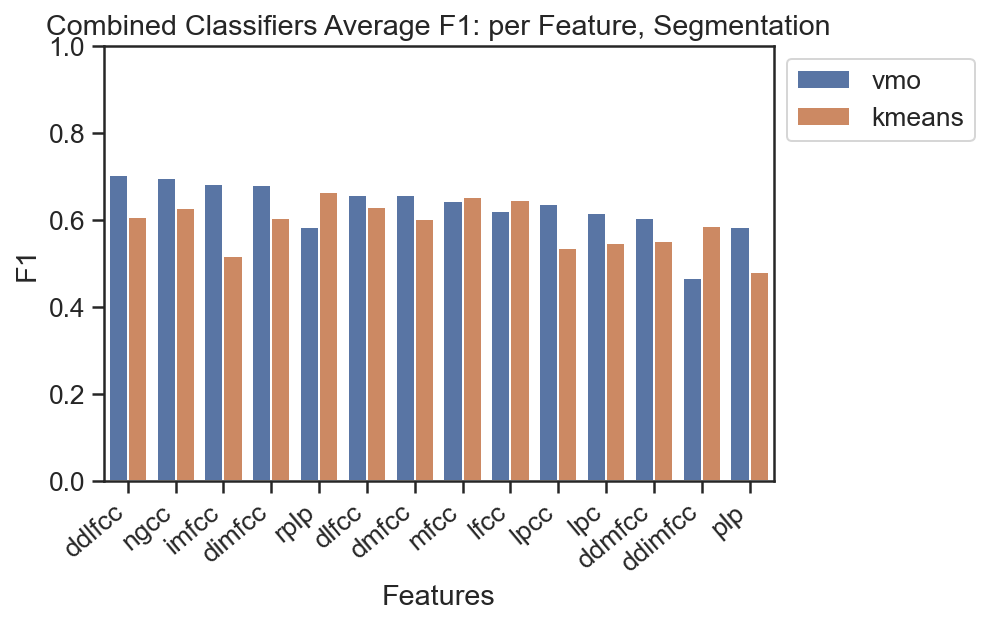

In [32]:
palette ={"vmo": "C0", "kmeans": "C1"}
results_df_IR['f1_means'] = (results_df_IR.LR_f1 + results_df_IR.KNN_f1 + results_df_IR.XGB_f1) / 3
results_df_IR = results_df_IR.sort_values(by='f1_means', ascending=False)

ax = sns.barplot(data=results_df_IR, x="feature", y='f1_means', hue='segmentation', palette=palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
ax.set_title('Combined Classifiers Average F1: per Feature, Segmentation')
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set(xlabel='Features', ylabel='F1', ylim=(0, 1))

### I

<ipython-input-33-01844f3d320e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_I['f1_means'] = (results_df_I.LR_f1 + results_df_I.KNN_f1 + results_df_I.XGB_f1) / 3


[Text(0.5, 0, 'Features'), Text(0, 0.5, 'F1'), (0.0, 1.0)]

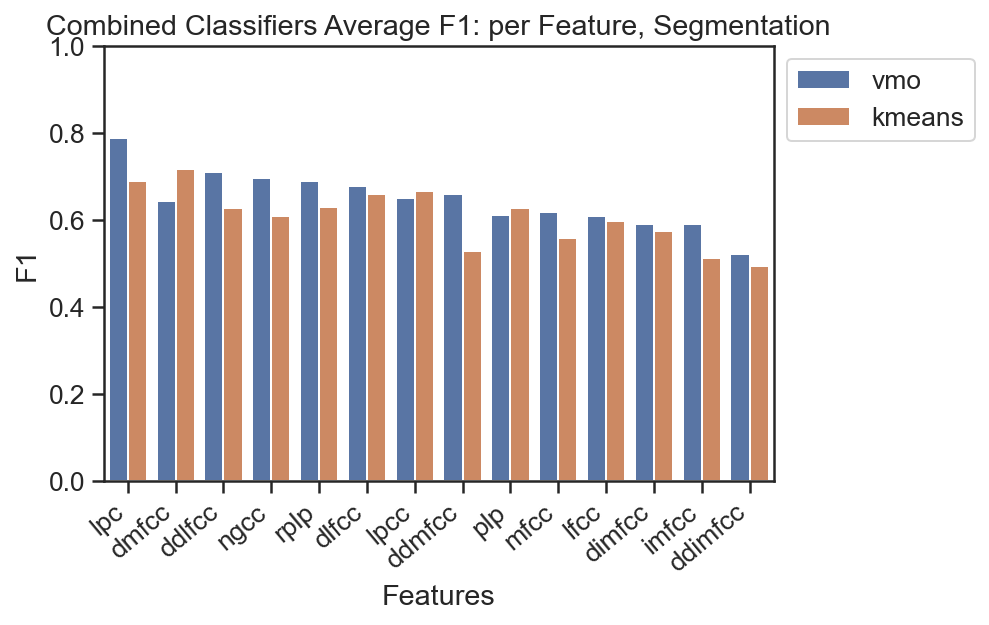

In [33]:
palette ={"vmo": "C0", "kmeans": "C1"}
results_df_I['f1_means'] = (results_df_I.LR_f1 + results_df_I.KNN_f1 + results_df_I.XGB_f1) / 3
results_df_I = results_df_I.sort_values(by='f1_means', ascending=False)

ax = sns.barplot(data=results_df_I, x="feature", y='f1_means', hue='segmentation', palette=palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
ax.set_title('Combined Classifiers Average F1: per Feature, Segmentation')
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set(xlabel='Features', ylabel='F1', ylim=(0, 1))

### Rand

<ipython-input-35-539afb073be7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results_df_Rand['f1_means'] = (results_df_Rand.LR_f1 + results_df_Rand.KNN_f1 + results_df_Rand.XGB_f1) / 3


[Text(0.5, 0, 'Features'), Text(0, 0.5, 'F1'), (0.0, 1.0)]

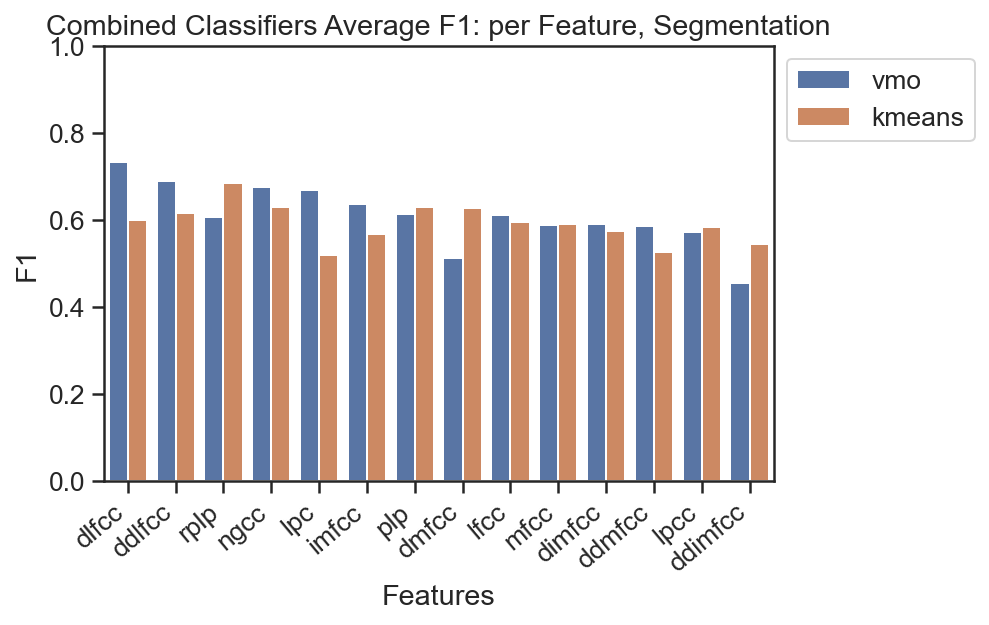

In [35]:
palette ={"vmo": "C0", "kmeans": "C1"}
results_df_Rand['f1_means'] = (results_df_Rand.LR_f1 + results_df_Rand.KNN_f1 + results_df_Rand.XGB_f1) / 3
results_df_Rand = results_df_Rand.sort_values(by='f1_means', ascending=False)

ax = sns.barplot(data=results_df_Rand, x="feature", y='f1_means', hue='segmentation', palette=palette)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
ax.set_title('Combined Classifiers Average F1: per Feature, Segmentation')
ax.legend(bbox_to_anchor=(1,1), loc="upper left")
ax.set(xlabel='Features', ylabel='F1', ylim=(0, 1))